In [80]:
# imports
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from pretty_confusion_matrix import pp_matrix_from_data
import random

In [81]:
def h(plist: list) -> float:
    '''
    Calculates entropy for a given list of probabilities
    :param list plist: List of probabilities for each of classes
    :retrun: Calculated entropy
    :rtype: float
    '''
    if abs(sum(plist)  - 1) > 0.1:
        raise Exception("Invalid list of probabilities")
    return sum([-x*np.log2(x) for x in plist])

def cal_df_entropy(d: pd.DataFrame, label_name: str) -> float:
    '''
    Calculates entropy of a Dataframe
    :param pd.DataFrame d: Selected pd.DataFrame
    :param label_name: Label column name in the given data frame
    :retrun: Calculated entropy
    :rtype: float
    '''
    return h([x / len(d[label_name]) for x in d[label_name].value_counts()])


def gini(plist: list) -> float:
    '''
    Calculates gini index for a given list of probabilities
    :param list plist: List of probabilities for each of classes
    :retrun: Calculated entropy
    :rtype: float
    '''
    if abs(sum(plist)  - 1) > 0.1:
        raise Exception("Invalid list of probabilities")
    return sum([x * (1-x) for x in plist])

def cal_df_gini(d: pd.DataFrame, label_name: str) -> float:
    '''
    Calculates gini index of a Dataframe
    :param pd.DataFrame d: Selected pd.DataFrame
    :param label_name: Label column name in the given data frame
    :retrun: Calculated entropy
    :rtype: float
    '''
    return gini([x / len(d[label_name]) for x in d[label_name].value_counts()])



In [82]:
LABEL = 'final evaluation'
dataset = pd.read_csv("nursery.csv")

# Converting string type categorical features to integers and saving the index in categorical_index
categorical_index = {}
for c in dataset.columns:
    dataset[c] = pd.Categorical(dataset[c])
    categorical_index[c] = list(dataset[c].cat.categories)
    dataset[c] = dataset[c].cat.codes

train_ds, test_ds = train_test_split(dataset, test_size=0.333)

dataset = None

display(train_ds)
display(test_ds)

,parents,has_nurs,form,children,housing,finance,social,health,final evaluation
3925,2,4,3,0,1,0,2,2,2
8051,1,4,1,1,0,0,1,1,2
889,2,2,0,0,2,1,0,2,3
9489,0,3,2,3,1,0,2,0,0
7165,1,0,1,0,1,0,2,2,2
...,...,...,...,...,...,...,...,...,...
97,2,3,0,1,1,1,0,2,1
9324,0,3,2,0,1,0,0,0,0
6440,1,1,1,3,0,1,1,1,2
1184,2,2,1,1,1,1,1,1,1


,parents,has_nurs,form,children,housing,finance,social,health,final evaluation
9622,0,2,0,2,0,1,2,2,1
3022,2,0,3,0,0,0,0,2,1
11448,0,0,1,0,0,0,0,0,0
9063,0,3,1,3,1,1,0,0,0
9933,0,2,1,3,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...
9593,0,2,0,1,1,0,0,1,2
9055,0,3,1,3,1,0,2,2,1
11896,0,0,2,0,2,0,0,2,2
4050,2,4,3,3,0,0,0,0,0


In [83]:
class Node:
    def __init__(self, value=None):
        self.value = value
        self.resolved = False
        self.children = []
        self.parent = None
        self.index = 0
        self.depth = 0

    def get_rule_set(self):
        cn = self # current node
        
        ruleSet = []
        traversed_nodes = []

        rule = []
        while True:
            if cn is None:
                break
            
            if len(cn.children) == 0:
                if rule not in ruleSet:
                    ruleSet.append('\t'.join(rule) + " => " + str(cn.value))
                
                del(rule[-1])
                cn = cn.parent
                continue
            
            f = False
            for i in range(len(cn.children)):
                if id(cn.children[i]) not in traversed_nodes:
                    traversed_nodes.append(id(cn.children[i]))
                    rule.append(f"{cn.value}={i}")
                    cn = cn.children[i]
                    f = True
                    break
            
            if not f:
                if len(rule) > 0:
                    del(rule[-1])
                cn = cn.parent
                continue
        
        return ruleSet
    
    def add_children(self, children: list):
        for child in children:
            assert isinstance(child, Node)
            child.parent = self
            child.index = len(self.children)
            child.depth = self.depth + 1
            self.children.append(child)
    
    def get_filtered_df(self, df: pd.DataFrame, all_features: list):
        '''
        Returns filtered dataset and remaining features up to the current node
        '''
        p = self.parent
        c = self
        used_features = []
        while p is not None:
            used_features.append(p.value)
            df = df[df[p.value] == c.index].copy()
            c = p
            p = p.parent

        t = all_features.copy()
        for x in used_features:
            t.remove(x)
        
        return df, t


In [84]:
MAX_DEPTH = 6
ig_method = cal_df_gini

all_features = list(train_ds.columns)
all_features.remove(LABEL)

dTree = Node()
current_node = dTree

while True:
    if current_node.value is not None:
        found_none = False
        for child in current_node.children:
            if child.value is None:
                found_none = True
                current_node = child
                break
        if not found_none:
            if current_node.parent == None:
                break
            current_node = current_node.parent
            continue
    
    cds, available_features = current_node.get_filtered_df(train_ds, all_features)

    if len(cds.index) == 0: # if no more samples are available for the current node just assign a random label
        current_node.resolved = True
        current_node.value = random.randint(0, len(categorical_index[LABEL]))
        current_node = current_node.parent
        continue
    if len(available_features) == 0 or cds[LABEL].nunique() == 1 or current_node.depth == MAX_DEPTH:
        current_node.resolved = True
        current_node.value = stats.mode(cds[LABEL].values).mode[0]
        current_node = current_node.parent
        continue

    max_ig = {'val': 0, 'name': 0} # max information gain value and it's index
    for feature in available_features:
        total_h = ig_method(cds, LABEL) # total entropy of current remaining samples
        feature_n = len(categorical_index[feature]) # number of unique values that the selected feature has

        total_n = len(cds)
        cp = 0 # conditional probibility
        for v in range(feature_n):
            sub_d = cds[cds[feature] == v].copy()
            if len(sub_d.index) == 0: # no need to add to cp sum because probability is 0
                continue
            cp += (len(sub_d) / total_n) * ig_method(sub_d, LABEL)

        ig = total_h - cp
        if ig > max_ig['val']:
            max_ig['val'] = ig
            max_ig['name'] = feature
    
    current_node.value = max_ig['name']
    current_node.add_children([Node() for x in range(len(categorical_index[max_ig['name']]))])

ruleSet = dTree.get_rule_set()

print(categorical_index)
print(len(ruleSet))
print('\n'.join(ruleSet))

{'parents': ['great_pret', 'pretentious', 'usual'], 'has_nurs': ['critical', 'improper', 'less_proper', 'proper', 'very_crit'], 'form': ['complete', 'completed', 'foster', 'incomplete'], 'children': ['1', '2', '3', 'more'], 'housing': ['convenient', 'critical', 'less_conv'], 'finance': ['convenient', 'inconv'], 'social': ['nonprob', 'problematic', 'slightly_prob'], 'health': ['not_recom', 'priority', 'recommended'], 'final evaluation': ['not_recom', 'priority', 'spec_prior', 'very_recom']}
425
health=0 => 0
health=1	has_nurs=0	parents=0	children=0	form=0	housing=0 => 1
health=1	has_nurs=0	parents=0	children=0	form=0	housing=1 => 2
health=1	has_nurs=0	parents=0	children=0	form=0	housing=2 => 2
health=1	has_nurs=0	parents=0	children=0	form=1 => 2
health=1	has_nurs=0	parents=0	children=0	form=2 => 2
health=1	has_nurs=0	parents=0	children=0	form=3 => 2
health=1	has_nurs=0	parents=0	children=1 => 2
health=1	has_nurs=0	parents=0	children=2 => 2
health=1	has_nurs=0	parents=0	children=3 => 2
h

[[2886    0    0    0]
 [   0 2756   45   22]
 [   0   73 2640    0]
 [   0   53    0  167]]


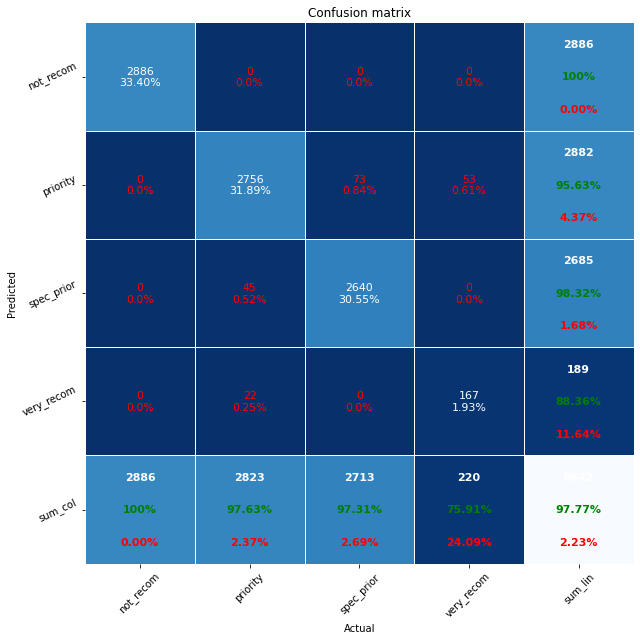

0.9776672066651239
[[1434    0    0    0]
 [   0 1384   36   23]
 [   0   63 1268    0]
 [   0   34    0   74]]


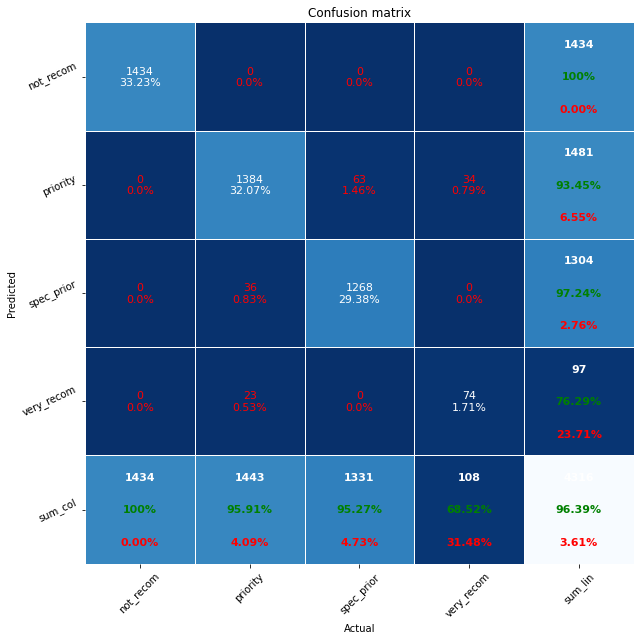

0.963855421686747


In [85]:
def predict(tree: Node, samples: pd.DataFrame):
    predictions = []
    for i, x in samples.iterrows():
        cn = tree # current_node
        while not cn.resolved:
            cn = cn.children[x[cn.value]]
        predictions.append(cn.value)
    return predictions

p = np.array(predict(dTree, train_ds))
r = train_ds[LABEL].values
print(confusion_matrix(r, p))
pp_matrix_from_data(r, p, cmap='Blues_r', columns=categorical_index[LABEL])
print(list((p - r)).count(0) / len(p))


p = np.array(predict(dTree, test_ds))
r = test_ds[LABEL].values
print(confusion_matrix(r, p))
pp_matrix_from_data(r, p, cmap='Blues_r', columns=categorical_index[LABEL])
print(list((p - r)).count(0) / len(p))